# Lab 2. Robust homography estimation: building image mosaics

In this practical session, we will create panoramic images by stitching multiple images of a scene taken from the same position, but pointing the camera to slightly different directions.  These images are related by homographies that we will need to compute.  The process will have the following steps:

- The first step will be to compute keypoints in the images that we can use to find correspondences.  We will use SIFT or ORB keypoints and features.
- Next we will compute correspondences between sets of keypoint features. We will use existing code for these first two steps.
- From the correspondences we will compute the homography that maps one image into the another. Since some correspondences may be erroneous, the computation will have to be robust to outliers. We will use the "RANdom SAmple Consensus" (RANSAC) method that you will have to complete.
- Finally, with the homographies computed, we will map all the images into a common canvas by using a variant of the  `apply_H` function from the last assignment.

Finally, you will have to answer the questions and complete the provided code when necessary as required. Some questions are rather theoretical and eventually imply some calculations while others are practical questions. **You must deliver the completed (and executed) ipynb file and a pdf file with the answers to the questions (included the parts of the code that need to be added).**

In [1]:
# ! pip install plotly
# tenemos esto comentado en el utils,!!!!!!!!

In [2]:
import numpy as np
import cv2
import random
import math
import sys
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter
from utils import apply_H_fixed_image_size, Normalization, DLT_homography

C:\Users\pansu\anaconda3\lib\site-packages\numpy
C:\Users\pansu\anaconda3\lib\site-packages\cv2\data
C:\Users\pansu\OneDrive\Documentos\3_trim_4rto\Vision_3D\3D_Vision_labs\Lab2_2022
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\User

In [3]:
!pip install opencv-contrib-python==4.4.0.46 # for SIFT

C:\Users\pansu\anaconda3\python38.zip
C:\Users\pansu\anaconda3\DLLs
C:\Users\pansu\anaconda3\lib
C:\Users\pansu\anaconda3
C:\Users\pansu\anaconda3
C:\Users\pansu
C:\Users\pansu\AppData\Roaming
C:\Users\pansu\anaconda3
C:\Users\pansu\anaconda3
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\lib\site-packages
C:\Users\pansu\anaconda3\l

ERROR: Invalid requirement: '#'


c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\pkginfo-1.5.0.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\pkginfo-1.5.0.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\pip-20.1.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\pip-20.1.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\pep8-1.7.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\pep8-1.7.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\patsy-0.5.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\patsy-0.5.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\use

In [41]:
def get_method(type_num):
    switcher = {
        0: "ORB",
        1: "SIFT",
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(type_num, "nothing")
## ESTARÍA GUAY PONER UN SWITCH Y LLAMAR A UNA FUNCIÓN U OTRA

# OBR method
flag_method = get_method(1)
flag_method

'SIFT'

## **1. Compute image correspondences**

The first step is to read the images and to compute their keypoints. The images are RGB. We have to convert them to gray scale with values in order to compute the keypoints on them. Then, we compute the keypoints and descriptors of every image. For the parts where the content of the two images coincide, you can visually check that many of the detected points are detected in both images. We want to find these _correspondences_.

c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\tables-3.6.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\sympy-1.6.1.dist-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\statsmodels-0.11.1-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\SQLAlchemy-1.3.18.dist-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\spyder-4.1.4.dist-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\spyder_kernels-1.9.2.dist-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\sphinxcontrib_websupport-1.2.3.dist-info
c:\users\pansu\anaconda3\lib\site-packages\sphinxcontrib_websupport-1.2.3.dist-info
C:\Users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anacon

build
build
build
C:\Users\pansu\anaconda3\Lib\site-packages
c:\users\pansu\appdata\local\pip\cache
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\zope.event-4.4-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\zope.event-4.4-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\zict-2.0.0-py3.6.egg-info
c:\users\pansu\anaconda3\lib\site-packages\zict-2.0.0-py3.6.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\xlwt-1.3.0-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\xlwt-1.3.0-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages
c:\users\pansu\anaconda3\lib\site-packages\xlwings-0.19.5-py3.8.egg-info
c:\users\pansu\anaconda3\lib\site-packages\xlwings-0.19.5-py3

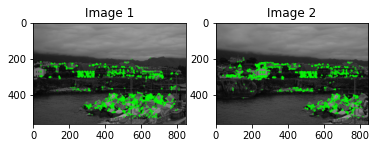

In [4]:
img1 = cv2.imread('Data/Llanes/llanes_a.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/Llanes/llanes_b.jpg',cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('Data/Llanes/llanes_c.jpg',cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# draw only keypoints location,not size and orientation
img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Image 1')
ax2.set_title('Image 2')
ax1.imshow(img1b); ax2.imshow(img2b)
plt.show()

**Q1.** Are the keypoints uniformly distributed over the image? Where are there more keypoints? Why?


To match the keypoints between two images, we need to assign to each keypoint in the first image the one that has the most similar descriptor in the second image. 

Execute the following code to find image correspondences using ORB [1] (you may also use SIFT [2], SURF [3], etc, an example of the use of SIFT is given in another code cell below).

[1] Ethan Rublee, Vincent Rabaud, Kurt Konolige, Gary R. Bradski. ORB: An efficient alternative to SIFT or SURF. ICCV, 2564-2571, 2011.

[2] David Lowe. Object recognition from local scale-invariant features. ICCV, 1150-1157, 1999.

[3] Herbert Bay, Tinne Tuytelaars, Luc Van Gool. Surf: Speeded up robust features. ECCV, 404-417, 2006.

<mark> <font size="3"> **Answer:** </mark>

en los puntos donde hay mas cambios de gradientes de la misma imag

<font size="3"> **ORB:** 

In [42]:
# # Keypoint matching
# bf = cv2.BFMatcher()
# matches_12 = bf.knnMatch(des1,des2,k=2)
# # Apply ratio test
# good_matches_12 = []
# for m,n in matches_12:
    
#     if m.distance < 0.85*n.distance:
#         good_matches_12.append([m])

# # Show "good" matches 
# img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(img_12)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.5)
# plt.show()

# Keypoint matching
# OBR method
def compute_orb(flag_method, img1, img2, des1, des2, kp1, kp2):
    if flag_method != "ORB":
        return
    
    bf = cv2.BFMatcher()
    matches_12 = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good_matches_12 = []
    for m,n in matches_12:

        if m.distance < 0.85*n.distance:
            good_matches_12.append([m])

    # Show "good" matches 
    img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()
    
    return good_matches_12, matches_12
    
good_matches_12 = compute_orb(flag_method, img1, img2, des1, des2, kp1, kp2)

In case you want to find SIFT correspondences you may use the code below. 

NOTE: SIFT is not available in certain OpenCV versions. A version that worked for us was opencv-contrib 4.4.0.46, you can install it with the following command: `pip install opencv-contrib-python==4.4.0.46`

 <font size="3"> **SIFT:** 

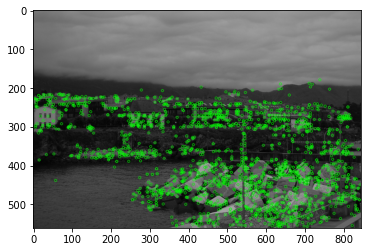

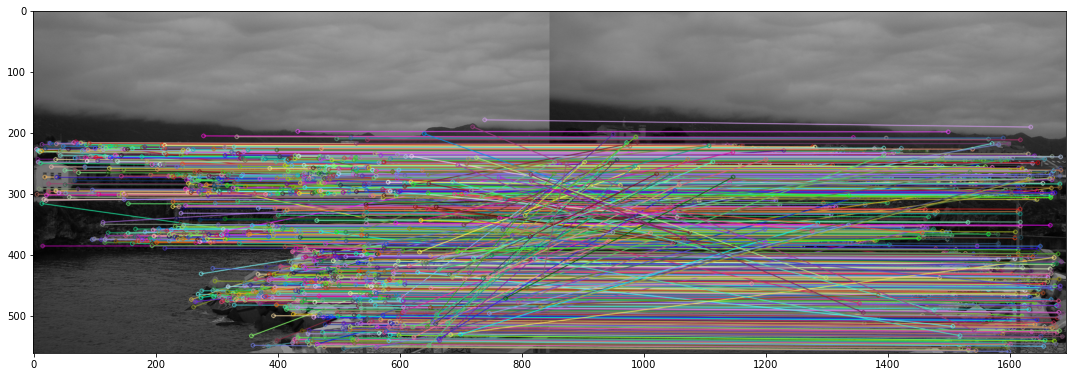

In [6]:
# Initiate SIFT detector
sift = cv2.SIFT_create(3000)

# find the keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# draw only keypoints location,not size and orientation
img1b = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.imshow(img1b), plt.show()

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_12 = bf.match(des1,des2)

# Show matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

**Q2.**
Compute and visualize the matchings between image 2 and 3. Write the commands you used for that.

**Q3.**
Are all the matchings correct? Why?

<mark> <font size="3"> **Answer:** </mark>
    
They are not the same, since they have a slighly change of view of the imgs

<mark> <font size="3"> **Between image 2 and 3:** </mark>

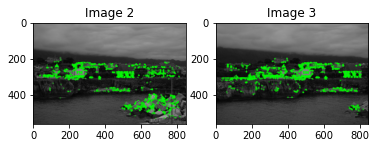

In [7]:
# Initiate ORB detector
orb = cv2.ORB_create(3000)
# find the keypoints and descriptors with ORB
kp2, des2 = orb.detectAndCompute(img2,None)
kp3, des3 = orb.detectAndCompute(img3,None)

# draw only keypoints location,not size and orientation
img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
img3b = cv2.drawKeypoints(img3, kp3, None, color=(0,255,0), flags=0)
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Image 2')
ax2.set_title('Image 3')
ax1.imshow(img2b); ax2.imshow(img3b)
plt.show()

<font size="3"> **ORB:** 

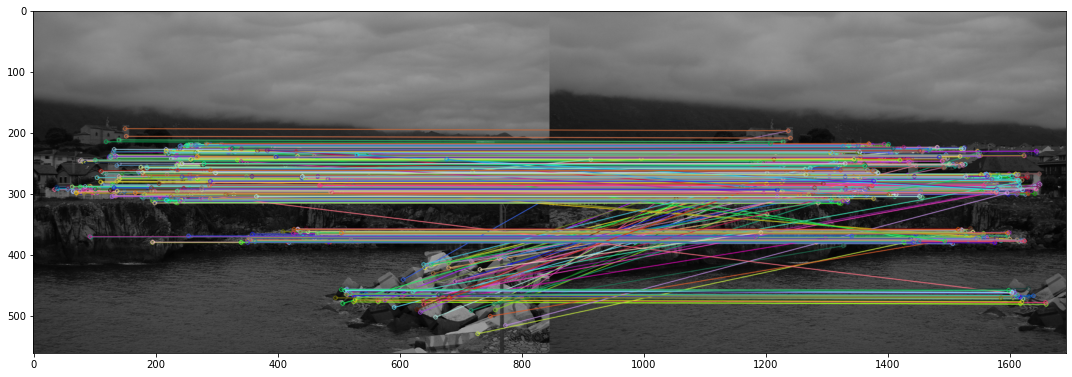

In [8]:
# Keypoint matching 
bf = cv2.BFMatcher()
matches_23 = bf.knnMatch(des2,des3,k=2)
# Apply ratio test
good_matches_23 = []
for m,n in matches_23:
    
    if m.distance < 0.85*n.distance:
        good_matches_23.append([m])

# Show "good" matches 
img_23 = cv2.drawMatchesKnn(img2,kp2,img3,kp3,good_matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_23)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<font size="3"> **SIFT:** 

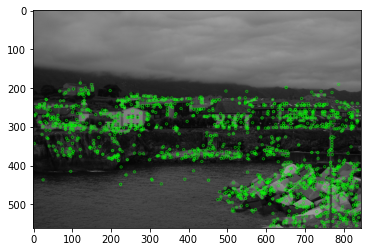

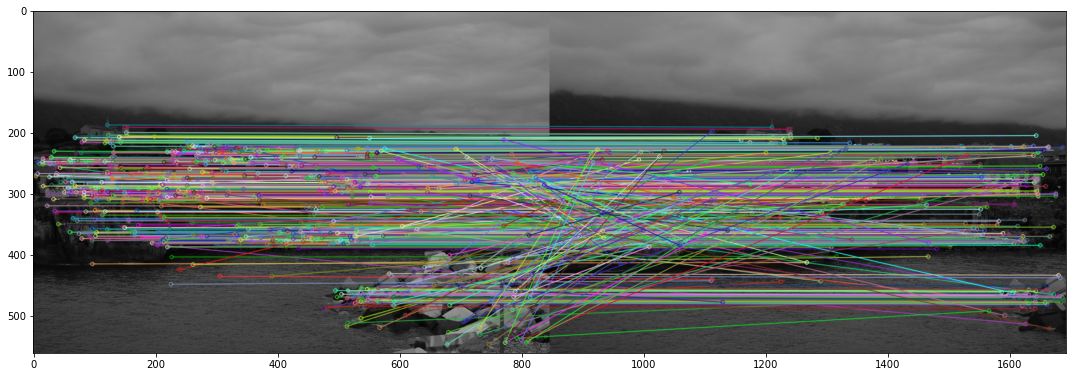

In [9]:
# Initiate SIFT detector
sift = cv2.SIFT_create(3000)

# find the keypoints and descriptors
kp2, des2 = sift.detectAndCompute(img2,None)
kp3, des3 = sift.detectAndCompute(img3,None)

# draw only keypoints location,not size and orientation
img2b = cv2.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)
plt.imshow(img2b), plt.show()

# Keypoint matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches_23 = bf.match(des2,des3)

# Show matches
img_23 = cv2.drawMatches(img2,kp2,img3,kp3,matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_23)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## **2. Compute the homography (robust DLT algorithm) between image pairs**

We want now to compute the homography that relates each pair of images. From  the last assignment, we have a function called `DLT_homography` that computes a homography given a set of correspondences. Unfortunately, this only works when all of the correspondences are correct, which is not the case in most practical applictions as the current one. This time, we will need to use the RANSAC method in order to find the correct correspondences and discard the others.

For that we use the functions `Ransac_DLT_homography` and `Inliers` that you have 
to complete below (this is part of questions Q5 and Q6 below).


In [10]:
def Inliers(H, points1, points2, th):
   
    # Check that H is invertible
    if abs(math.log(np.linalg.cond(H))) > 15: 
        idx = np.empty(1)
        return idx
    
    inliers_indices = []
    points1/=points1[2,:]
    points2/=points2[2,:]
    # complete this code .......
    for j in range(points1.shape[1]):
        x_prima_j = points2[:,j]
        x_j = points1[:,j]
        
        dist1 = x_prima_j - np.dot(H, x_j)
        dist2 = np.dot(np.linalg.inv(H),x_prima_j)-x_j
        dist = np.linalg.norm(dist1) + np.linalg.norm(dist2)
        
        if dist<th:
            print(dist)
            inliers_indices.append(j)
    
    
    return np.asarray(inliers_indices)

In [11]:
def Ransac_DLT_homography(points1, points2, th, max_it):
    
    Ncoords, Npts = points1.shape
    
    it = 0
    best_inliers = np.empty(1)

    while it < max_it:
        L = 4
        indices = random.sample(range(1, Npts), L)
        H = DLT_homography(points1[:,indices], points2[:,indices])
        inliers = Inliers(H, points1, points2, th)
        
        # test if it is the best model so far
        if inliers.shape[0] > best_inliers.shape[0]:
            best_inliers = inliers
            print(best_inliers.shape)
        it += 1
    
    # compute H from all the inliers
    H = DLT_homography(points1[:,best_inliers], points2[:,best_inliers])
    inliers = best_inliers
    
    return H, inliers
    

The following code allows to robustly estimate the homography that relates images 1 and 2. Examine the code and answer the questions below.

In [12]:
# # # Homography between images 1 and 2
# points1 = []
# points2 = []
# for m in good_matches_12: # matches_12 instead, if you use SIFT
#     points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
#     points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT
    
# points1 = np.asarray(points1)
# points1 = points1.T
# points2 = np.asarray(points2)
# points2 = points2.T




In [13]:
# # Homography between images 1 and 2 SIFTTTT
points1 = []
points2 = []
for m in matches_12: # matches_12 instead, if you use SIFT
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1]) # m.queryIdx instead, if you use SIFT
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1]) # m.trainIdx instead, if you use SIFT
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T



In [14]:
points1.shape

(3, 1032)

In [15]:
# # OBR
# th = 10
# H_12, indices_inlier_matches_12 = Ransac_DLT_homography(points1, points2, th, 1000)
# inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(good_matches_12) # matches_12 instead, if you use SIFT

# # drawMatches instead of drawMatchesKnn if you use SIFT
# img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.imshow(img_12)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.5)
# plt.show()

In [17]:
points1

array([[  5.448246  ,   6.25787973,   7.41186619, ..., 821.5994873 ,
        831.34875488, 834.37786865],
       [227.09674072, 300.93371582, 243.54026794, ..., 406.0357666 ,
        485.5463562 , 434.99685669],
       [  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ]])

8.80292287756041
8.80292287756041
6.015109102225296
5.069865211248656
5.069865211248656
5.213762775827744
5.789590992910712
6.021545290579902
6.021545290579902
6.021545290579902
7.49158333116912
9.611649519630774
8.850137627561168
8.575559661702963
8.808319203956904
9.586681001646436
9.586681001646436
8.13144715301117
9.010554807653858
9.659283282531314
(20,)
9.638305058824098
9.37276861562866
9.832595255562886
9.745695522705166
9.65050306743713
8.762026759911926
9.5082576280453
9.408539192362735
8.282934302823797
9.27356485725335
9.27356485725335
9.38955704802363
9.518398273812872
9.72343457800843
8.667495890638243
8.84778415433745
8.84778415433745
8.388804661892738
8.489566039658165
9.277837252037958
8.150910787796938
8.560279077192046
8.033662836299392
8.950880971335799
9.0132565554731
7.463097430415442
7.463097430415442
8.241967501366869
7.498145514420716
8.459490936741457
7.572214286892832
8.574350036472193
7.583217722284832
7.583217722284832
9.562109402038228
7.4128296096969715
8

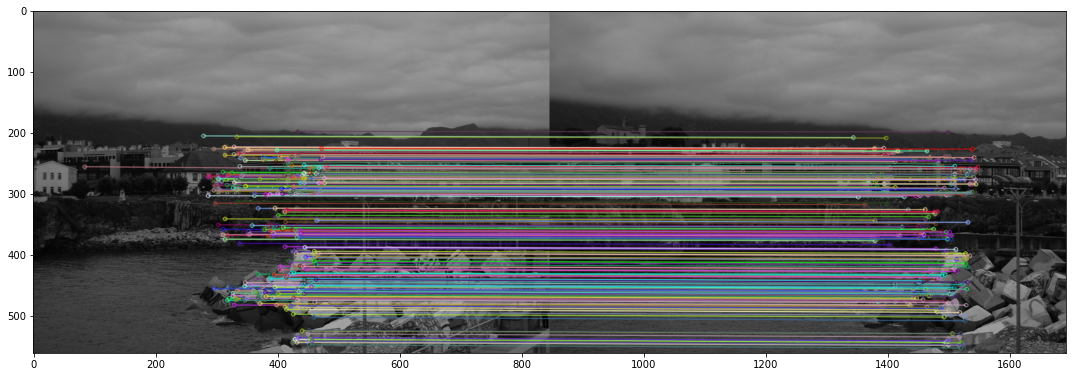

In [18]:
# SIFT
th = 10
H_12, indices_inlier_matches_12 = Ransac_DLT_homography(points1, points2, th, 3)
inlier_matches_12 = itemgetter(*indices_inlier_matches_12)(matches_12) # matches_12 instead, if you use SIFT

# drawMatches instead of drawMatchesKnn if you use SIFT
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

**Q4.** What are the variables `points1` and `points2`?

Complete the `Ransac_DLT_homography` function by answering the following questions:

**Q5.** Set the number of samples to choose randomly and that will define the model to test in each trial. (second input parameter of function `random.sample`).

**Q6.** Complete the function `Inliers` by computing the geometric error of the correspondences given the homography.

**Q7.** What is the input parameter `th` when calling the `Ransac_DLT_homography` function? Choose a good value for this parameter and justify your answer.

**Q8.** Create a new function `Ransac_DLT_homography_adaptive_loop` which is based on the function `Ransac_DLT_homography` and automatically adapts the number of trials to ensure we pick, with a probability $p=0.99$ an initial data set with no outliers.

**Q9.** Compare experimentally the two versions of the RANSAC algorithm (`Ransac_DLT_homography` and `Ransac_DLT_homography_adaptive_loop`) in terms of the number of iterations. Which version is better and why?

**Q10.** Compute the homography that relates images 2 and 3. Write the commands you used for that.

In [ ]:
# code to complete here ...



## **3. Build the mosaic**

At this point we have all the ingredients to built the image mosaic. For transforming an image with a specified homography we use a modification of the function `apply_H` used in the previous practical session. The modified function `apply_H_fixed_image_size` transforms the input image according to the input homography and writes it in an output image of size corresponding to the input vector of desired corner coordinates.

Examine and complete the code below when necessary.

**Q11.** Which homography we use for transforming the image 2? Why?

**Q12.** How are the two images combined in the mosaic image? Why?

**Q13.** Complete the mosaic including the third image. Write the commands you used for that.

In [ ]:
corners = [-400, 1200, -100, 650]

#print(img1.shape)
img1c = cv2.imread('Data/Llanes/llanes_a.jpg',cv2.IMREAD_COLOR)
img2c = cv2.imread('Data/Llanes/llanes_b.jpg',cv2.IMREAD_COLOR)
img3c = cv2.imread('Data/Llanes/llanes_c.jpg',cv2.IMREAD_COLOR)
img1c = cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB)
img2c = cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB)
img3c = cv2.cvtColor(img3c, cv2.COLOR_BGR2RGB)

# mosaic 1-2
img1c_w = apply_H_fixed_image_size(img1c, H_12, corners)
img2c_w = apply_H_fixed_image_size(img2c, np.identity(3), corners)
img_mosaic_12 = np.maximum(img1c_w,img2c_w)
plt.imshow(img_mosaic_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

# mosaic 1-2-3
# ... complete ...


**Q14.** **(Optional)** Create a function that takes as input the path to the folder where the images to construct the panorama are located. The function should work independently of the number of images that are located in the folder (assume that the images are given in the correct order).

In [ ]:
def P = panorama(path_images):
    # INPUTS:
        #path_images: path to the folder that contain the images
    # OTPUT: 
        # P: panoarama image 
        
    
    # READ ALL THE IMAGES OF THE INPUT PATH  
    
    # COMPUTE THE IMAGE KEYPOINTS OF THE IMAGES
    
    # MATCH THE KEYPOINTS
    
    #COMPUTE THE HOMOGRAPIES
    
    #BUILD THE MOSAIC
        
        
    

**Q15** Construct the panorana image of each folder present in the Data folder and explain why it works or not in each case. In the scenarios that it does not work properly, suggest how you would try to improve the result obtained.

Note 1 : Use the function created above if the case, otherwise repeate the code for each pair of images.

Note 2: You will need to define new corner for panoram as the images bigger and positioned different, trick look the dimension of the images to thefine the corners of each case.